# Spam

In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.stats import multivariate_normal
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
import glob as g
import re
import pdb

### Load Data

In [2]:
spamfiles = g.glob('./spam/spam/*.txt')
hamfiles = g.glob('./spam/ham/*.txt')
testfiles = ['./spam/test/' + str(i) + '.txt' for i in range(10000)]

In [3]:
def load_process_files(files):
    txts = list()
    for file in files:
        txt = open(file, "r", encoding='utf-8', errors='ignore').read()
        txt = txt.replace('\r\n', ' ')
        txts.append(txt)
    return txts

In [4]:
spams = load_process_files(spamfiles)
hams = load_process_files(hamfiles)
tests = load_process_files(testfiles)
trains = spams + hams
all = trains + tests

In [5]:
Ns = len(spams); Nh = len(hams); Nt = len(tests)
validate_n = 10000
vectorizer = TfidfVectorizer(min_df=0.05)

data = vectorizer.fit_transform(all).toarray()
train_data = data[:-10000]
test_data = data[-10000:]

spam_data = train_data[:Ns]
spam_validate = spam_data[validate_n:]

ham_data = train_data[Ns:]
ham_validate = ham_data[validate_n:]

spam_prior =  math.log(1.0 * Ns / (Ns  + Nh))
ham_prior = math.log(1.0 * Nh / (Ns  + Nh))

c = 0.0001

### Model

In [15]:
def gaussian_mean_cov(data):
    mu = np.mean(data, axis=0)
    sigma = np.cov(data, rowvar=0)
    return mu, sigma


def lda_train(spam, ham, all):
    x = normalize(all.astype(np.float32))
    sigma = np.cov(x, rowvar=0)
    mu1, _ = gaussian_mean_cov(spam)
    mu2, _ = gaussian_mean_cov(ham)
    m1 = multivariate_normal(mu1, sigma + c * np.identity(sigma.shape[0]))
    m2 = multivariate_normal(mu2, sigma + c * np.identity(sigma.shape[0]))
    return m1, m2


def qda_train(spam, ham):
    mu1, sigma1 = gaussian_mean_cov(spam)
    mu2, sigma2 = gaussian_mean_cov(ham)
    m1 = multivariate_normal(mu1, sigma1 + c * np.identity(sigma1.shape[0]))
    m2 = multivariate_normal(mu2, sigma2 + c * np.identity(sigma2.shape[0]))
    return m1, m2
    

def test(x, spam_m, ham_m):
    y = list()
    for sample in x:
        spam_y = spam_m.logpdf(sample) + spam_prior
        ham_y = ham_m.logpdf(sample) + ham_prior
        y.append(np.argmax([ham_y, spam_y]))
    return y


def evaluate(spam_data, ham_data, spam_m, ham_m):
    spam_y = test(spam_data, spam_m, ham_m)
    ham_y = test(ham_data, spam_m, ham_m)
    correct = np.count_nonzero(spam_y) + (len(ham_y) - np.count_nonzero(ham_y))
    total = len(spam_y) + len(ham_y)
    return 1.0 * correct / total


def batch_train_and_evaluate(spam_data, ham_data, spam_validate, ham_validate, categories, type="LDA"):
    errors = []
    for size in categories:
        spam_m, ham_m = qda_train(spam_data[:size, :], ham_data[:size, :])
        if type == "LDA":
            all = np.concatenate((spam_data, ham_data), axis=0)
            spam_m, ham_m = lda_train(spam_data[:size, :], ham_data[:size, :], all)
        err = 1 - evaluate(spam_validate, ham_validate, spam_m, ham_m)
        errors.append(err)
        print("Error for training size {}: {}".format(size, err))
    
    plt.plot(categories, errors, 'ro')
    plt.axis([min(categories)-10, max(categories)+10, -0.1, max(errors)+0.1])
    plt.title("{} Error rate".format(type)) 
    return spam_m, ham_m

Error for training size 100: 0.3400864397622907
Error for training size 200: 0.32685035116153427
Error for training size 500: 0.3001080497028633
Error for training size 1000: 0.217720151269584
Error for training size 2000: 0.18989735278227982


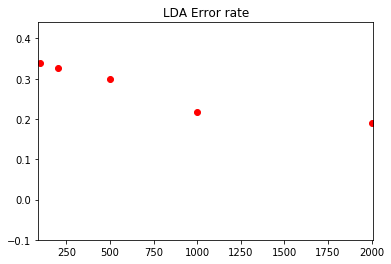

In [16]:
# Train
categories = [100, 200, 500, 1000, 2000]
lda_models = batch_train_and_evaluate(spam_data, ham_data, spam_validate, ham_validate, categories, type="LDA")

Error for training size 100: 0.13479200432198812
Error for training size 200: 0.11561318206374938
Error for training size 500: 0.11642355483522415
Error for training size 1000: 0.09751485683414374
Error for training size 2000: 0.09292274446245274


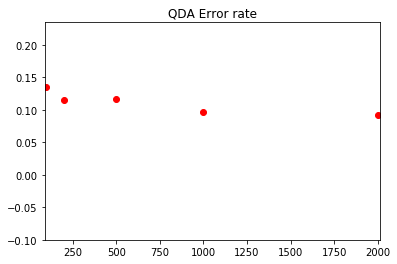

In [17]:
qda_models = batch_train_and_evaluate(spam_data, ham_data, spam_validate, ham_validate, categories, type="QDA")

In [24]:
# Test
lda_y = test(test_data, lda_models[0], lda_models[1])
qda_y = test(test_data, qda_models[0], qda_models[1])

In [25]:
df = pd.DataFrame(data = lda_y, columns=["Category"]) 
df.index.name = "Id"
df.to_csv("./spam.csv")

### Kaggle:  0.95520
Feature Description:  
Used bag of words approach plus normalization. More specifically, the features are the freqencies of each unique word in the text; after normalization, they become probabilities.  